### Notebook for finetuning model

Model to finetune is allegro/herbert-base-cased. Do finetunningu zostaną zamrożone wszystkie warstwy oprócz ostatnich 4.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch import softmax
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel, EvalPrediction, Trainer, TrainingArguments

In [2]:
class HateClassifier(nn.Module):
    def __init__(self, model_name="allegro/herbert-base-cased", num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Linear(hidden_size, num_labels)
        self.dropout = nn.Dropout(0.2)
        self.loss_fn = nn.CrossEntropyLoss()


        for param in self.bert.parameters():
            param.requires_grad = False

        for layer_idx in range(8, 12):
            for param in self.bert.encoder.layer[layer_idx].parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls = out.last_hidden_state[:, 0, :]
        x = self.dropout(cls)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


### Prepare Data

In [3]:
df = pd.read_csv("data/train.csv")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df["Class"])

In [4]:
class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [5]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

train_dataset = HateDataset(train_df["Text"].tolist(), train_df["Class"].tolist(), tokenizer)
val_dataset = HateDataset(val_df["Text"].tolist(), val_df["Class"].tolist(), tokenizer)

### Training

In [6]:
import numpy as np

def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids
    logits = eval_pred.predictions 

    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    proba = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    y_pred_proba = proba[:, 1]

    y_pred = (y_pred_proba >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

In [7]:
def train(
        model,
        train_dataset,
        val_dataset,
        output_dir="model_output",
        epochs=3,
        batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_steps=50,
        seed=42
):
    torch.manual_seed(seed)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        eval_strategy="steps",
        logging_steps=logging_steps,
        save_steps=save_steps,
        eval_steps=save_steps,         
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=seed,
        fp16=torch.cuda.is_available()
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()
    print("Final evaluation metrics:", metrics)
    return trainer, trainer.model

In [8]:
def plot_training(trainer):
    df = pd.DataFrame(trainer.state.log_history)
    df_train = df.dropna(subset=["loss"])
    df_eval = df.dropna(subset=["eval_loss"])

    plt.figure(figsize=(10, 5))

    plt.plot(df_train["step"], df_train["loss"], label="Training Loss")
    plt.plot(df_eval["step"], df_eval["eval_loss"], label="Validation Loss")

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_metrics(trainer):
    df = pd.DataFrame(trainer.state.log_history)
    metrics = ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        df_metric = df.dropna(subset=[metric])
        axes[i].plot(df_metric["step"], df_metric[metric], marker='o')
        axes[i].set_title(metric)
        axes[i].set_xlabel("Step")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


### Try training

In [9]:
device = torch.device("cuda")
model = HateClassifier()
model.to(device)

trainer, trained_model = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    output_dir="./funetune_hate_model",
    epochs=3,
    batch_size=64,
    learning_rate=2e-5,
    logging_steps=20,
)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.650700,0.517595,0.765741,0.724922,0.856481,0.785229
100,0.365500,0.334774,0.853241,0.856209,0.849074,0.852627
150,0.330800,0.343835,0.852778,0.802862,0.935185,0.863986
200,0.328100,0.295105,0.872685,0.843137,0.915741,0.877941
250,0.294900,0.277618,0.887037,0.918838,0.849074,0.882579
300,0.300700,0.257240,0.888889,0.870370,0.913889,0.891599
350,0.267800,0.264836,0.889352,0.869833,0.915741,0.892197
400,0.246600,0.268318,0.887963,0.859966,0.926852,0.892157
450,0.269300,0.252107,0.891204,0.867711,0.923148,0.894572
500,0.252100,0.249661,0.899537,0.882875,0.921296,0.901676


Final evaluation metrics: {'eval_loss': 0.23858021199703217, 'eval_accuracy': 0.9037037037037037, 'eval_precision': 0.8906810035842294, 'eval_recall': 0.9203703703703704, 'eval_f1': 0.9052823315118397, 'eval_runtime': 1.2101, 'eval_samples_per_second': 1785.021, 'eval_steps_per_second': 28.098, 'epoch': 3.0}


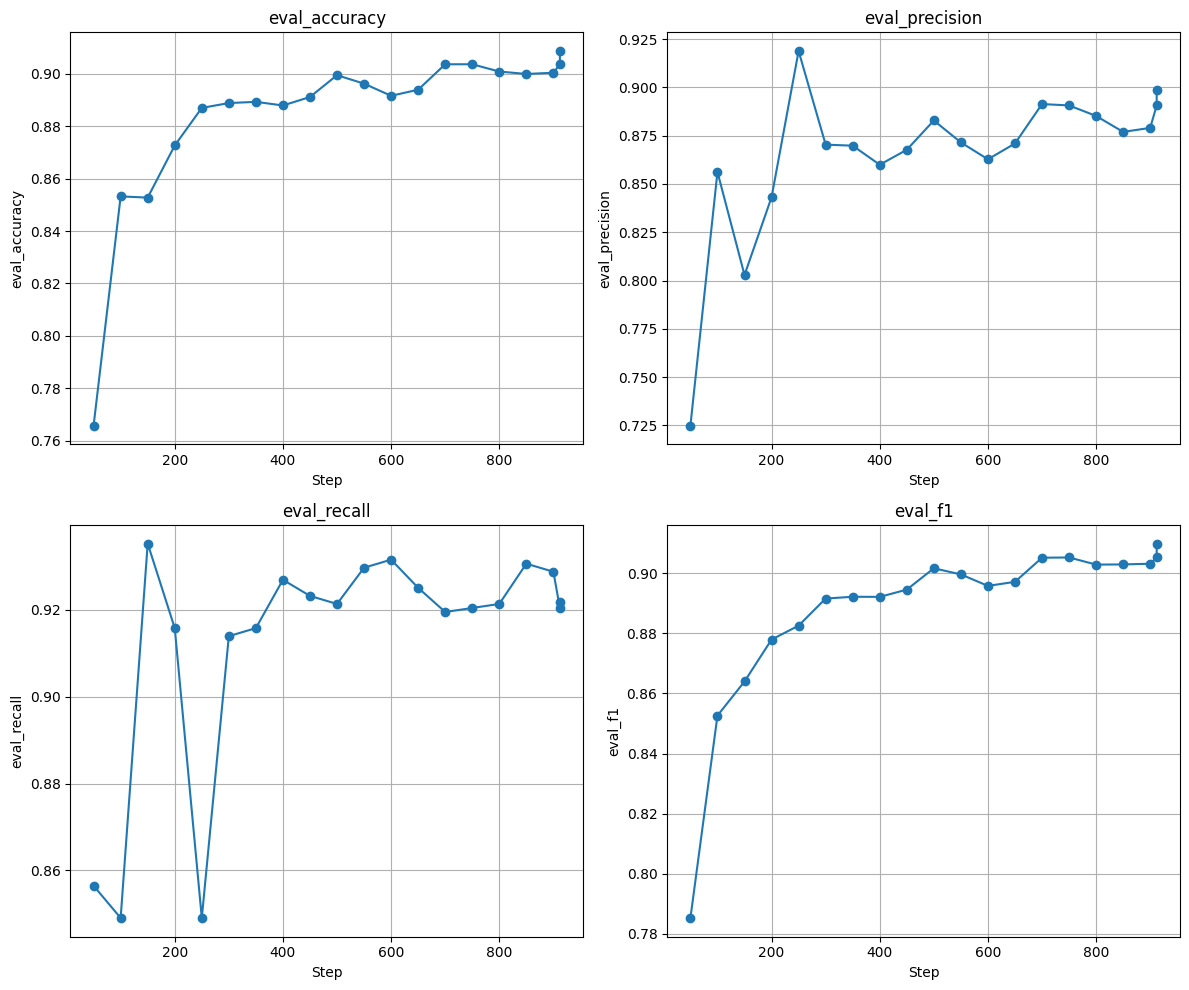

In [14]:
plot_metrics(trainer)

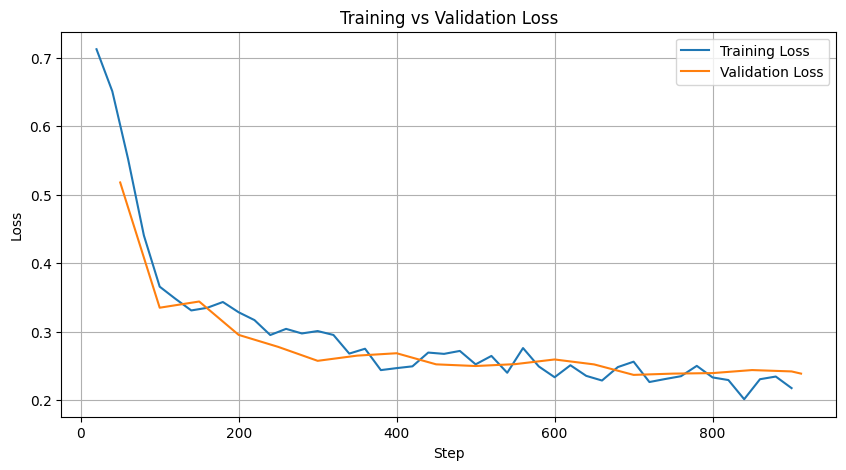

In [11]:
plot_training(trainer)

In [15]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
df_logs.to_csv("finetune_training_logs.csv", index=False)

### Testing model

In [16]:
test_df = pd.read_csv("data/test.csv")
test_dataset = HateDataset(test_df["Text"].tolist(), test_df["Class"].tolist(), tokenizer)

metrics = trainer.evaluate(eval_dataset=test_dataset)
print(metrics)


{'eval_loss': 0.22181233763694763, 'eval_accuracy': 0.90875, 'eval_precision': 0.8984565393988627, 'eval_recall': 0.9216666666666666, 'eval_f1': 0.9099136157959687, 'eval_runtime': 1.5861, 'eval_samples_per_second': 1513.162, 'eval_steps_per_second': 23.958, 'epoch': 3.0}
